#### Warm Up | Master's Thesis
# VARIATIONAL MONTE CARLO

#### WHAT IS NETKET

The `NetKet` package has specifically developed for Variational Monte Carlo calculations.

NetKet is throughly documented in [its publication](https://scipost.org/SciPostPhysCodeb.7/pdf) and partly in its [online documentation](https://netket.readthedocs.io/en/latest/index.html). When in doubt, check those, and if you find no answer, ask on our official [discussion forum](https://github.com/orgs/netket/discussions).

#### DEFINING THE HAMILTONIAN

The aim of this notebook is to find the Ground State of a transverse field Ising model in 2D. We assume periodic boundary conditions.

$$
\mathcal{H}=-h\sum_{i}\sigma_{i}^{(x)}+J\sum_{\langle i,j \rangle}\sigma_{i}^{(z)}\sigma_{j}^{(z)}.
$$

Normally, to write a VMC code you would have to implement yourself a way to compute matrix elements of the operators, as well as code to run a Monte-Carlo sampler, but for sanity and peace of mind in this tutorial we will use NetKet to do it.

`NetKet` requires 3 steps to create a Hamiltonian. First we define the basic structure of the system as a hypergraph. More precisely, a $4 \times 4$ system with periodic boundary conditions. This allows for easy access of vertices and edges of the system.

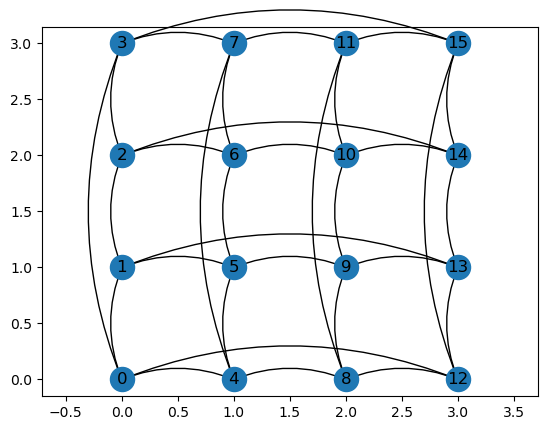

In [1]:
import netket as nk

L = 4
g = nk.graph.Hypercube(length=L, n_dim=2, pbc=True)
g.draw();

The second step is to define a computational space (or basis) in which we can perform our calculations. We can constrain this combinatorial space by imposing a total magnetization of $0$ allowing only for spin combinations with equal number of up and down spins.

This is somewhat a fundamental object, and you must often declare it. Mainly, it defines how many degrees of freedom you have and how you store configurations. In this case, the hilbert space stores them as a local variable $+1$ or $-1$.

In [2]:
hi = nk.hilbert.Spin(s=1/2, N=g.n_nodes)

Then we must define the Hamiltonian. In `NetKet` you can build individual operators acting on a site.

The functions in `nk.operator.spin` and `nk.operator.boson` are used to create the fundamental operators that can be used to build arbitrary observables and Hamiltonians.

Those functions return an object of type `LocalOperator`, which behaves as some sort of sparse matrix that is optimised to be used in the context of Variational Monte Carlo.

This is extremely similar to the concept of the `MultiQubitMeasurement` I introduced in the QST warm-up. They are restricted to one site only resulting in a very sparse matrix that can be optimized during the VMC.

We do a quick comparison to verify with a 3 site system.

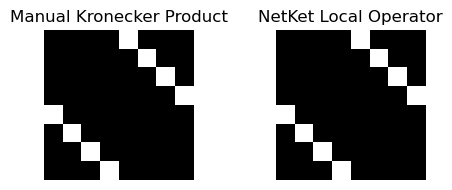

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# manual approach using the Kronecker product
sigma_0 = np.eye(2)
sigma_x = np.array([[0, 1], [1, 0]])
H_kron = np.kron(np.kron(sigma_x, sigma_0), sigma_0)

# multi-step NetKet approach
test_g = nk.graph.Chain(length=3)
test_hi = nk.hilbert.Spin(s=1/2, N=test_g.n_nodes)
test_sx_1 = nk.operator.spin.sigmax(test_hi, 0)
H_nk = test_sx_1.to_dense() # the internal representation is sparse, but we can convert it to dense for comparison


fig, axs = plt.subplots(1, 2, figsize=(5, 2))

axs[0].imshow(H_kron, cmap='gray', interpolation='nearest')
axs[0].set_title("Manual Kronecker Product")
axs[1].imshow(H_nk, cmap='gray', interpolation='nearest')
axs[1].set_title("NetKet Local Operator")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

Knowing this, we can construct our hamiltonian by iterating over the sites in our graph:

In [4]:
hamiltonian = nk.operator.LocalOperator(hi)

# the first part of the Hamiltonian just acts on one spin with negative sign
for site in g.nodes():
    hamiltonian -= nk.operator.spin.sigmax(hi, site)

# the second part of the Hamiltonian acts on two spins
for edge in g.edges():
    hamiltonian += nk.operator.spin.sigmaz(hi, edge[0]) @ nk.operator.spin.sigmaz(hi, edge[1])


# we perform a sanity check with the inbuilt Ising operator
hamiltonian_correct = nk.operator.Ising(hi, g, h=1.0, J=1.0)
assert np.sum(np.abs(hamiltonian_correct.to_sparse() - hamiltonian.to_sparse())**2) < 1e-5

Most operators in NetKet are implemented in `numba` and they are not compatible with `jax.jit`. However, some particular operator formats are implemented both in `numba`and in a `jax.jit-`compatible format.

First we convert the hamiltonian from the `LocalOperator` format to the `PauliStrings` format by calling `.to_pauli_strings()`, and then we convert the `PauliStrings` operator to the jax format by calling `to_jax_operator()`.

We can even convert it to a sparse matrix from the `jax.experimental.sparse` module.

In [5]:
hamiltonian_jax = hamiltonian.to_pauli_strings().to_jax_operator()
hamiltonian_jax.to_sparse() # the output BCSR stands for Block Compressed Sparse Row, which is the sparse matrix format in JAX

BCSR(float64[65536, 65536], nse=1114112)

#### EXACT DIAGONALIZATION

Up to $N=24$ sites, we can still compute the exact ground state energy using brute-force exact diagonalization. The `scipy` library can calculate the lowest eigenvalue efficiently using a sparse matrix representation.

Note that the standard hamiltonian can be converted to a scipy sparse matrix easily, while the jax-hamiltonian is converted to a jax sparse matrix.



In [8]:
from scipy.sparse.linalg import eigsh

e_gs, psi_gs = eigsh(hamiltonian.to_sparse(), k=1)
e_gs = e_gs[0]
psi_gs = psi_gs.reshape(-1)

print(e_gs)

# sanity check
assert e_gs.shape == ()
assert psi_gs.shape == (hi.n_states, )
assert -34.02 < e_gs < -34.00

#### VARIATIONAL THERMALIZATION

For larger systems the exact diagonalization is not feasible. Instead, we can use a variational Monte Carlo method to find the ground state.

**Mean-Field Ansatz**

In the mean-field ansatz, we approximate the wavefunction as a product of single-spin wavefunctions. Lets say we want to model the outcome when measuring all spins in the $z$-direction. We can write the wavefunction as product of single-spin probabilities:

$$
\langle \sigma^{z}_1,\dots \sigma^{z}_N| \Psi_{\mathrm{mf}} \rangle = \Pi_{i=1}^{N} \Phi(\sigma^{z}_i),
$$

The single-spin wavefunction gives the probability of measuring spin up or down. They have to sum to one, so we can write them as:

$$
|\Phi(\uparrow)|^2+|\Phi(\downarrow)|^2=1
$$

We want to define the wave-function in polar form, defining it in the complex plane with magnitude and phase:

$$
\Phi(\sigma^z) = \sqrt{P(\sigma^z)}e^{i \phi(\sigma^z)}
$$

The magnitude encodes some measurement probability (square of the amplitude). Further, we assume that this probability has a sigmoid form depending on the Pauli matrix $\sigma^z$ scaled by a variational parameter $\lambda$. This arises due to the sigmoid function being a continuous approximation of the step function.

$$
P(\sigma_z; \lambda) = 1/(1+\exp(-\lambda \sigma_z))
$$




Since the ground state is real and positive, we set the phase $\phi = 0$. The wave-function $\Phi(\sigma^z)$ in polar form becomes:

$$
\Phi(\sigma^z) = \sqrt{P(\sigma^z)}
$$

Taking the logarithm:

$$
\log \Phi(\sigma^z) = \frac{1}{2} \left( -\log \left( 1 + \exp \left( -\lambda \sigma^z \right) \right) \right)
$$

The factor $\frac{1}{2}$ arises because the wave-function is defined as the square root of the probability $P(\sigma^z)$, and taking the logarithm of the square root introduces this factor. Summing over all spins gives the final log-probability of the entire spin configuration:

$$
\log \Psi_{\mathrm{mf}}(\sigma^z_1, \dots, \sigma^z_N) = \frac{1}{2} \sum_{i=1}^{N} -\log \left( 1 + \exp(-\lambda \sigma_i^z) \right)
$$

In `NetKet` one has to define a variational function approximating the **logarithm** of the wave-function amplitudes (or density-matrix values).

$$
\langle \sigma^{z}_1,\dots \sigma^{z}_N| \Psi_{\mathrm{mf}} \rangle = \exp\left[\mathrm{Model}(\sigma^{z}_1,\dots \sigma^{z}_N ; \theta ) \right]
$$

Here, $\theta$ is a set of parameters or for this case, simply a single parameter $\lambda$.
In this case, the parameter of the model will be just one: $\lambda$.

The Model can be defined using one of the several *functional* jax frameworks such as Jax/Stax, Flax or Haiku. Some Flax models and layers are already included in `NetKet`.


In [9]:
import jax
import jax.numpy as jnp
import flax.linen as nn


# building the model with jax makes its parameters differentiable
class MF(nn.Module):
    @nn.compact
    def __call__(self, x):
        lam = self.param("lambda", nn.initializers.normal(), (1,), float)
        prob = nn.log_sigmoid(lam*x)
        total_prob = 0.5 * jnp.sum(prob, axis=-1)
        return total_prob

In [10]:
# initializing the model with a random seed
model = MF()
key = jax.random.PRNGKey(0)
params = model.init(key, np.random.rand(hi.size))


# perform inference by passing forward 4 samples (16 x 4 tensor)
inputs = hi.random_state(jax.random.key(1), (4,))
log_psi = model.apply(params, inputs)
log_psi

**Calculating State Vectors**

The model will evaluate $\log \psi$ not the wavefunction itself. Furthermore, we would like the model to return a state vector over the entire Hilbert space, which is $2^N$ large.

Just to be clear, when defining the model we modelled the wave function when performing the measurement $\bra{\sigma^z_1, \dots, \sigma^z_N}$. This is a single configuration of spins. We can now evaluate the model for all possible configurations of spins.

In [11]:
def to_array(model, params):
    all_configurations = hi.all_states()
    logpsi = model.apply(params, all_configurations)
    psi = jnp.exp(logpsi)
    psi = psi / jnp.linalg.norm(psi)
    return psi


# sanity check
assert to_array(model, params).shape == (hi.n_states, )
assert np.all(to_array(model, params) > 0)
np.testing.assert_allclose(np.linalg.norm(to_array(model, params)), 1.0)

In [13]:
hi.all_states().shape

If you implemented everything correctly using `jnp.` operations and not `np.` operations, we might as well be able to jit-compile the function to gain a speed boost!

In [14]:
%timeit to_array(model, params)

In [17]:
# for compilation, we have to specify which arguments to treat as a compile-time constant.
to_array_jit = jax.jit(to_array, static_argnames="model")

# run it once to compile it, before benchmarking
to_array_jit(model, params)

Array([0.0042355 , 0.00419265, 0.00419265, ..., 0.0036364 , 0.0036364 ,
       0.00359962], dtype=float64)

In [18]:
%timeit to_array_jit(model, params)

4.83 ms ± 55.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**Calculating the Energy**

Now, the observable we want to minimize is the energy. For this we need to compute the expectation value of the Hamiltonian according to the formula:

$$
\langle \mathcal{H} \rangle = \frac{\langle \Psi | \mathcal{H} | \Psi \rangle}{\langle \Psi | \Psi \rangle} = \frac{\langle \Psi | \mathcal{H} | \Psi \rangle}{1}
$$

What this operation does is basically some summing over all the basis states.

In [15]:
def compute_energy(model, params, hamiltonian):
    # first compute the state vector
    psi_gs = to_array(model, params)

    # then we compute the expectation value
    H_exp = psi_gs.conj().T@(hamiltonian@psi_gs)
    return H_exp


# sanity check
assert compute_energy(model, params, hamiltonian.to_sparse()).shape == ()
assert compute_energy(model, params, hamiltonian.to_sparse()) < 0

In [20]:
# we compile it again and measure performance for different sparse representations
compute_energy_jit = jax.jit(compute_energy, static_argnames="model")
hamiltonian_sparse = hamiltonian.to_sparse()
hamiltonian_jax_sparse = hamiltonian_jax.to_sparse()

%timeit compute_energy(model, params, hamiltonian_sparse)
%timeit compute_energy_jit(model, params, hamiltonian_jax_sparse)

11 ms ± 23.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
21.4 ms ± 193 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


**Gradient of the Energy**

Just like in `pytorch` or `tensorflow`, we can compute the gradient of the energy by calling `jax.grad` on the energy function.

We can use the `@partial` decorator to directly `jit` the function (including any function it calls).



In [16]:
from functools import partial

@partial(jax.jit, static_argnames='model')
def compute_energy_and_gradient(model, params, hamiltonian_sparse):
    grad_fun = jax.value_and_grad(compute_energy, argnums=1)
    return grad_fun(model, params, hamiltonian_sparse)

**Iterative Optimisation of the Energy**

Now we perform gradient descent just like when we train any neural network. We are only dealing with one variable and can update it directly with a learning rate.

`NetKet` provides a covenient runtime logger that accumulates data for each step as a dictionary.

In [20]:
from tqdm import tqdm

# initialization
model = MF()
params = model.init(jax.random.key(0), np.ones((hi.size, )))
logger = nk.logging.RuntimeLog()

for i in tqdm(range(100)):
    energy, gradient = compute_energy_and_gradient(model, params, hamiltonian_jax_sparse)

    # step
    params = jax.tree.map(lambda p, g: p - 0.01 * g, params, gradient)

    logger(step=i, item={'Energy': energy})

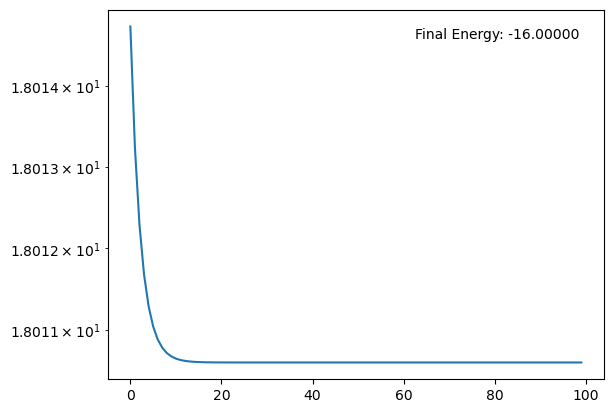

In [23]:
# since we dumped the data in a dictionary, we can easily plot it in log scale

final_energy = compute_energy(model, params, hamiltonian_jax_sparse)

plt.semilogy(logger.data['Energy']['iters'], np.abs(logger.data['Energy']['value']- e_gs))
plt.text(0.95, 0.95, f"Final Energy: {final_energy:.5f}", ha='right', va='top', transform=plt.gca().transAxes)
plt.show()

#### JASTROW ANSATZ

Now we have a framework for calculating the ground state energy we can use a more expressive ansatz. The Jastrow ansatz models the wavefunction as a product of pairwise correlations between spins.

$$
\langle \sigma^{z}_1,\dots \sigma^{z}_N| \Psi_{\mathrm{jas}} \rangle = \exp \left( \sum_{ij}\sigma_i J_{ij}\sigma_j\right)
$$


In [16]:
class Jastrow(nn.Module):
    @nn.compact
    def __call__(self, x):
        n_sites = x.shape[-1]

        J = self.param("J", nn.initializers.normal(), (n_sites,n_sites), float)

        # gets the more restrictive type between the two, we don't know whether the initializer supports x.dtype
        dtype = jnp.promote_types(J.dtype, x.dtype)
        J = J.astype(dtype)
        x = x.astype(dtype)

        # the initialization of J is not symmetric, so we symmetrize it
        J_symm = J.T + J

        # einstein summation iterating over all possible pairs of spins ensuring that we have the matching indices for J
        total_prob = jnp.einsum("...i,ij,...j", x, J_symm, x)
        return total_prob


# sanity checks
model_jastrow = Jastrow()

one_sample = hi.random_state(jax.random.key(0))
batch_samples = hi.random_state(jax.random.key(0), (5,))
multibatch_samples = hi.random_state(jax.random.key(0), (5,4,))

parameters_jastrow = model_jastrow.init(jax.random.key(0), one_sample)
assert parameters_jastrow['params']['J'].shape == (hi.size, hi.size)
assert model_jastrow.apply(parameters_jastrow, one_sample).shape == ()
assert model_jastrow.apply(parameters_jastrow, batch_samples).shape == batch_samples.shape[:-1]
assert model_jastrow.apply(parameters_jastrow, multibatch_samples).shape == multibatch_samples.shape[:-1]

NameError: name 'nn' is not defined

In [15]:
from tqdm import tqdm

model = Jastrow()
params = model.init(jax.random.key(0), np.ones((hi.size, )))
logger = nk.logging.RuntimeLog()

for i in tqdm(range(200)):
    energy, gradient = compute_energy_and_gradient(model, params, hamiltonian_jax_sparse)
    params = jax.tree.map(lambda p, g: p - 0.01 * g, params, gradient)
    logger(step=i, item={'Energy': energy})

NameError: name 'Jastrow' is not defined

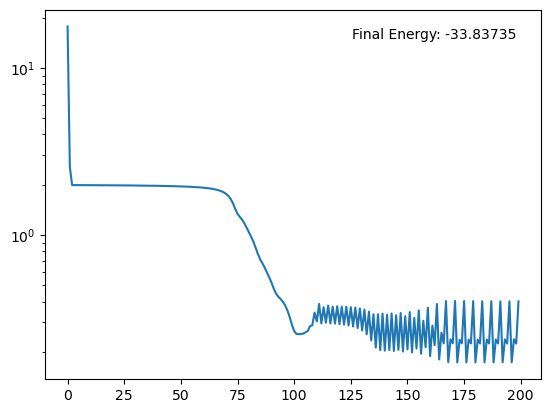

In [26]:
final_energy = compute_energy(model, params, hamiltonian_jax_sparse)

plt.semilogy(logger.data['Energy']['iters'], np.abs(logger.data['Energy']['value']- e_gs))
plt.text(0.95, 0.95, f"Final Energy: {final_energy:.5f}", ha='right', va='top', transform=plt.gca().transAxes)
plt.show()

#### MONTE CARLO SAMPLING

Calculating the expectation value of the Hamiltonian according to $\langle \mathcal{H} \rangle = \langle \Psi | \mathcal{H} | \Psi \rangle$ is not feasible for large systems. Instead, we would like to sample states, that are most likely to appear in the ground state. Basically, we would like to sample the following distribution:

$$
P(\mathbf{r})=\left|\psi_0(\mathbf{r})\right|^2
$$

Here, the argument $\mathbf{r}=\left(s_1, s_2, \ldots, s_N\right), \quad s_i \in\{+1,-1\}$ represents a possible configuration.


We can use Monte Carlo sampling to estimate the expectation value. `NetKet` already provides a MCMC sampler that proposes new states by flipping individual spins in a Spin Chain.

----

#### INTERMEZZO: Metropolis-Hastings Algorithm

The goal of the Metropolis-Hastings algorithm is to approximate a target distribution $p(\theta)$ that we cannot sample from directly. Instead, we assume that $p(\theta)$ is proportional to some known function $g(\theta)$:

$$
p(\theta) \propto g(\theta)
$$

**Steps**

1. Select an initial parametrization of the model $\theta_0$

2. Generate a Markov chain of samples over steps $i = 1, \ldots, m$:

   - a) Draw a candidate $\theta^*$ from a proposal distribution $q(\theta^* \mid \theta_{i-1})$.

     > This proposal distribution encodes our Markov step

   - b) Compute the acceptance ratio $\alpha$:
     $$
     \alpha = \frac{g(\theta^*) / q(\theta^* \mid \theta_{i-1})}{g(\theta_{i-1}) / q(\theta_{i-1} \mid \theta^*)}
     $$

     $$
     \alpha=\underbrace{\frac{g\left(\theta^*\right)}{g\left(\theta_{i-1}\right)}}_{\text {Push toward better } \theta^*} \times \underbrace{\frac{q\left(\theta_{i-1} \mid \theta^*\right)}{q\left(\theta^* \mid \theta_{i-1}\right)}}_{\text {Proposal asymmetry correction }}
     $$

     > The assymetry correction tells us how likely it is to jump back to the old parametrization compared to jumping into the new one.

   - c) Accept or reject the candidate $\theta^*$:

     - If $\alpha \geq 1$, accept the candidate $\theta^*$ and set $\theta_i \leftarrow \theta^*$
     - If $0<\alpha<1$, accept $\theta^*$ with probability $\alpha$

3. **Get final distribution**:

   The final approximation of the target distribution $p(\theta)$ can be retrieved from the sequence of parameter values generated by the Markov chain after discarding the initial $n_{\text{burn}}$ values (burn-in period). These remaining parameter values $\{\theta_{n_{\text{burn}}}, \ldots, \theta_m\}$ are treated as samples that approximate the target distribution.

   Since consecutive parameter values may exhibit autocorrelation, thinning (keeping every $k$-th value) can be applied to improve the independence of the retained samples.

Source: https://www.youtube.com/watch?v=0lpT-yveuIA

----



**Correspodences**

| **Metropolis-Hastings**                               | **Monte Carlo Sampling (Spin Chain)**                        |
| ----------------------------------------------------- | ------------------------------------------------------------ |
| Parametrization $\theta$                              | Spin configuration $\mathbf{r}$                              |
| Proposal distribution $q(\theta^* \mid \theta_{i-1})$ | Random spin flip proposal $q(\mathbf{r}^* \mid \mathbf{r}_{i-1})$ |
| Target distribution $p(\theta)$                       | Probability distribution $P(\mathbf{r}) = |\psi_0(\mathbf{r})|^2$ |
| Final distribution after convergence                  | Final configurations representing $P(\mathbf{r})$            |



In [13]:
transition_rule = nk.sampler.rules.LocalRule()
sampler = nk.sampler.MetropolisSampler(hi, transition_rule, n_chains=20)

**Sampler Usage**
 - First you initialise the 'sampler state' that contains the mutable state and rng of the sampler
 - Every time you change the parameters you should reset it with `sampler.reset`
 - to generate new samples you call .sample_chain.

Using independent sampling chains is just a trick to parallelize the sampling process. So if we have 20 chains of length 100 we basically want to generate 2000 samples.

In [14]:
sampler_state = sampler.init_state(model, params, seed=1)
sampler_state = sampler.reset(model, params, sampler_state)
samples, sampler_state = sampler.sample(model, params, state=sampler_state, chain_length=100)
samples.shape

NameError: name 'model' is not defined

#### COMPUTING THE ENERGY FROM MONTE CARLO SAMPLES

We previously calculated the energy as the expectation value of the Hamiltonian:
$$
\langle H\rangle=\frac{\langle\psi| H|\psi\rangle}{\langle\psi \mid \psi\rangle}
$$
For now, will only expand $\langle\psi|$ in the computational basis and leave $|\psi\rangle$ as it is:

$$
\langle\psi|=\sum_\sigma \psi^*(\sigma)\langle\sigma|
$$

$$
\langle H\rangle=\frac{\sum_\sigma \psi^*(\sigma)\langle\sigma| H|\psi\rangle}{\langle\psi \mid \psi\rangle}
$$

We can further simplify this expression by introducing a **local energy**. This term basically tells us how much a single configuration $\sigma$ contributes effectively to the Hamiltonian $H$ given the wave function $\psi$:
$$
E_{\mathrm{loc}}(\sigma)=\frac{\langle\sigma| H|\psi\rangle}{\langle\sigma \mid \psi\rangle}=\frac{\langle\sigma| H|\psi\rangle}{\psi(\sigma)}
$$
This will give us:
$$
\langle H\rangle=\frac{\sum_\sigma \psi^*(\sigma)\left[E_{\mathrm{loc}}(\sigma) \psi(\sigma)\right]}{\langle\psi \mid \psi\rangle}=\frac{\sum_\sigma|\psi(\sigma)|^2 E_{\mathrm{loc}}(\sigma)}{\sum_\sigma|\psi(\sigma)|^2}
$$
The probability of a certian basis state to appear is given by:
$$
P(\sigma)=\frac{|\psi(\sigma)|^2}{\sum_\eta|\psi(\eta)|^2}
$$
Which gives us:
$$
\langle H\rangle=\sum_\sigma P(\sigma) E_{\mathrm{loc}}(\sigma)
$$


In practice, the sum over all possible configurations $\sigma$ is often too large to compute directly.

Markov chain Monte Carlo (MCMC) allows us to sample $\sigma$ according to $P(\sigma) \propto|\psi(\sigma)|^2$. Suppose you generate $N$ independent samples $\left\{\sigma_1, \sigma_2, \ldots, \sigma_N\right\}$ from this distribution. A 'more important' $\sigma$ will appear more often in this set. By dividing its frequency by $N$ we model its probability $P(\sigma)$.

To model the expectation value of the energy, we simply sum over the local energies associated with each state configuration $\sigma_n$:
$$
\langle H\rangle \approx \frac{1}{N} \sum_{n=1}^N E_{\mathrm{loc}}\left(\sigma_n\right)
$$
Now what there is left to do, is to define a proper way to calculate this local energy for a given configuration:
$$
E_{\mathrm{loc}}(\sigma)=\frac{\langle\sigma| H|\psi\rangle}{\psi(\sigma)}=\frac{\sum_{\eta} \langle \sigma | H | \eta \rangle \psi(\eta)}{\psi(\sigma)}
$$
We have $\langle \sigma | H | \eta \rangle$ as matrix elements of the Hamiltonian in this basis. We have a similar scaling problem like before. However, we know that the Hamiltonian is local and sparse.  In a lattice, $H$ usually consists of terms acting on nearest-neighbors. This means, there are only a few configurations where $\langle\sigma| H|\eta\rangle \neq 0$:
$$
E_{\mathrm{loc}}(\sigma)=\sum_{\eta \text { s.t. }\langle\sigma| H|\eta\rangle \neq 0}\langle\sigma| H|\eta\rangle \frac{\psi(\eta)}{\psi(\sigma)}=\sum_{\eta \text { s.t. }\langle\sigma| H|\eta\rangle \neq 0}\langle\sigma| H|\eta\rangle \exp [\log \psi(\eta)-\log \psi(\sigma)]
$$

Luckily, our `NetKet` Hamiltonian already has methods supporting exactly the retrival of those  nearest-neighbor terms. This operator also supports batch operations.



In [29]:
# getting the connected matrix elements for a given configuration
sigma = hi.random_state(jax.random.key(1))
sigma_string = "".join(["+" if s == 1 else "-" for s in sigma])

eta, H_sigma_eta = hamiltonian_jax.get_conn_padded(sigma)
print(f"We have {eta.shape[0]} spin configurations connected to the given spin configuration {sigma_string}")

# getting a whole batch of connected configurations
sigma_batch = hi.random_state(jax.random.key(1), 4)
eta_batch, H_sigma_eta_batch = hamiltonian_jax.get_conn_padded(sigma_batch)
print(f"We a total of {eta_batch.shape[0]*eta_batch.shape[1]} connected configurations for the batch of {sigma_batch.shape[0]}")

We have 17 spin configurations connected to the given spin configuration +--+-+--+---++++
We a total of 68 connected configurations for the batch of 4


In [12]:
# defining a function for the local energy

def compute_local_energies(model, parameters, hamiltonian_jax, sigma):
    eta, H_sigma_eta = hamiltonian_jax.get_conn_padded(sigma)

    logpsi_sigma = model.apply(parameters, sigma)
    logpsi_eta = model.apply(parameters, eta)

    # broadcast the logpsi_sigma to match the dimensions of logpsi_eta
    logpsi_sigma = jnp.expand_dims(logpsi_sigma, -1)
    res = jnp.sum(H_sigma_eta * jnp.exp(logpsi_eta - logpsi_sigma), axis=-1)
    return res


# sanity checks
assert compute_local_energies(model, params, hamiltonian_jax, samples[0]).shape == samples.shape[1:-1]
assert compute_local_energies(model, params, hamiltonian_jax, samples).shape == samples.shape[:-1]

# this can be compiled too
jax.jit(compute_local_energies, static_argnames='model')(model, params, hamiltonian_jax, sigma)

NameError: name 'model' is not defined

#### SAMPLING THE ENERGY

Now that we are able to calculate the local energy for a given configuration, we want to calculate the expectation value of the energy over a given number of samples. We can also estimate the error of this expectation value:

$$
\epsilon_E = \sqrt{\frac{\mathbb{V}\text{ar}(E_\text{loc})}{N_\text{samples}}}
$$

Running it on the final optimized model from before should result approximately in the exact ground state energy.

In [33]:
@partial(jax.jit, static_argnames='model')
def estimate_energy(model, parameters, hamiltonian_jax, sigma):
    E_loc = compute_local_energies(model, parameters, hamiltonian_jax, sigma)

    E_average = jnp.mean(E_loc)
    E_variance = jnp.var(E_loc)
    E_error = jnp.sqrt(E_variance / E_loc.size)

    # we return a netket Stats object that wraps all statistical information related to this mean value.
    return nk.stats.Stats(mean=E_average, error_of_mean=E_error, variance=E_variance)


# sanity check using trained model and previous samples
isinstance(estimate_energy(model, params, hamiltonian_jax, samples), nk.stats.Stats)
print(estimate_energy(model, params, hamiltonian_jax, samples))

-33.814 ± 0.096 [σ²=18.325]


In [11]:
# more samples should give a better estimate
samples_many, sampler_state = sampler.sample(model, params, state=sampler_state, chain_length=5000)

print("exact: ", compute_energy(model, params, hamiltonian_jax))
print("estimate: ", estimate_energy(model, params, hamiltonian_jax, samples_many))

NameError: name 'sampler' is not defined

#### SAMPLING THE GRADIENT OF THE ENERGY

For our training loop we need to compute gradients for backpropagation. Since our energy is a scalar and our parameters form a vector, we expect the gradient to be a vector of the same shape as the parameters:

$$
\nabla_k E=\mathbb{E}_{\sigma \sim|\dot{\psi}(\sigma)|^2}\left[\left(\nabla_k \log \psi(\sigma)\right)^*\left(E_{\mathrm{loc}}(\sigma)-\langle E\rangle\right)\right]
$$

We skipped the full derivation for now. In the context of Monte Carlo sampling, we can estimate the gradient as:

$$
    \nabla_k E \approx \frac{1}{N_s}\sum_i^{N_s} (\nabla_k \log\psi(\sigma_i))^\star \left( E_\text{loc}(\sigma_i) - \langle E \rangle\right)
$$

Here $\langle E\rangle$ can be estimated as $\langle E\rangle \approx \frac{1}{N,} \sum_i E_{\mathrm{loc}}\left(\sigma_i\right)$.

We can think of $\nabla_k \log\psi(\sigma_i)$ as the _JACOBIAN_ of the function $\log\psi_\sigma : \mathbb{R}^{N_\text{pars}} \rightarrow \mathbb{R}^{N_\text{samples}}$, and think for a moment of $E_\text{loc}(\sigma_i)$ as a vector of size $\mathbb{R}^{N_\text{samples}}$



In [10]:
# we reshape the MC samples into a single batch of vectors (N_pars x N)
sigma_vector = samples.reshape(-1, hi.size)

# just as before, the model produces a state vector. Passing the sigma vector through it will give the logpsi_sigma
logpsi_sigma_fun = lambda pars : model_jastrow.apply(parameters_jastrow, sigma_vector)

# input to the function are only the parameters, output is a vector of size n samples
print("N_samples is equal to: ", logpsi_sigma_fun(parameters_jastrow).shape)

NameError: name 'samples' is not defined

In [40]:
# calculating the jacobian of this function
jacobian = jax.jacrev(logpsi_sigma_fun)(parameters_jastrow)

print("The parameters of Jastrow have shape:\n" , jax.tree.map(lambda x: x.shape, parameters_jastrow))
print("The jacobian of Jastrow have shape:\n" , jax.tree.map(lambda x: x.shape, jacobian))

The parameters of jastrow have shape:
 {'params': {'J': (16, 16)}}
The jacobian of jastrow have shape:
 {'params': {'J': (2000, 16, 16)}}


In [42]:
# now we want to get an estimate for the energy and its gradient

@partial(jax.jit, static_argnames='model')
def estimate_energy_and_gradient(model, parameters, hamiltonian_jax, sigma):
    # reshape the samples to a vector of samples with no extra batch dimensions
    sigma = sigma.reshape(-1, sigma.shape[-1])

    E_loc = compute_local_energies(model, parameters, hamiltonian_jax, sigma)

    # compute the energy as well
    E_average = jnp.mean(E_loc)
    E_variance = jnp.var(E_loc)
    E_error = jnp.sqrt(E_variance/E_loc.size)
    E = nk.stats.Stats(mean=E_average, error_of_mean=E_error, variance=E_variance)

    # define the function to be differentiated
    logpsi_sigma_fun = lambda pars : model.apply(pars, sigma)
    # jax.vjp provides an on-demand (lazy) way to get the gradients of logpsi_sigma_fun
    _, vjpfun = jax.vjp(logpsi_sigma_fun, parameters)
    E_grad = vjpfun((E_loc - E_average)/E_loc.size)
    return E, E_grad[0]

**Explanation**

The call `jax.vjp` is akin to a wrapper that provides fine-grained control over differentiation by separating the **forward pass** from the **backward pass**. This is similar to using the `autograd` module in `PyTorch`.

```python
_, vjpfun = jax.vjp(logpsi_sigma_fun, parameters)
E_grad = vjpfun((E_loc - E_average)/E_loc.size)
```

**Forward evaluation** (`_`): JAX calls `logpsi_sigma_fun(parameters)` and internally keeps a "tape" of operations to enable reverse-mode differentiation.

**Backward pass** (`vjpfun(...)`): By passing in $(E_{\mathrm{loc}} - E_{\mathrm{avg}})/N_s$ as the "cotangent" vector, JAX computes the vector-Jacobian product. Concretely, if
$$
\mathbf{y} = \bigl[\log\psi(\sigma_1), \log\psi(\sigma_2), \ldots, \log\psi(\sigma_{N_s})\bigr]
$$

then

$$
\mathrm{vjpfun}\bigl(\mathbf{v}\bigr) = \nabla_\theta \Bigl( \mathbf{v}^\mathsf{T}\,\mathbf{y} \Bigr)
   = \sum_{i=1}^{N_s} v_i \,\nabla_\theta \log\psi(\sigma_i).
$$
By choosing $\mathbf{v} = (E_{\mathrm{loc}}(\sigma_i) - E_{\mathrm{avg}})/N_s$, you get exactly the sum
$$
\frac{1}{N_s}
   \sum_{i=1}^{N_s}
   \Bigl(E_{\mathrm{loc}}(\sigma_i) - E_{\mathrm{avg}}\Bigr)\,\nabla_\theta \log\psi(\sigma_i),
$$
matching the variational Monte Carlo gradient formula.

### 4.5: Let's get down to business

Now let's wrap everything up and let's use this code to compute the ground state with an SGD optimisation using the mean field and jastrow ansatz

#### ITERATIVE OPTIMIZATION USING MONTE CARLO SAMPLING

Let's try MCMC with the Jastrow ansatz:

In [45]:
from tqdm import tqdm

# defining model and sampler
model = Jastrow()
sampler = nk.sampler.MetropolisSampler(hi, nk.sampler.rules.LocalRule(), n_chains = 20)
n_iters = 300
chain_length = 1000//sampler.n_chains

# initializing model and sampler
parameters = model.init(jax.random.key(0), np.ones((hi.size, )))
sampler_state = sampler.init_state(model, parameters, seed=1)

logger = nk.logging.RuntimeLog()
for i in tqdm(range(n_iters)):

    # sample states
    sampler_state = sampler.reset(model, parameters, state=sampler_state)
    samples, sampler_state = sampler.sample(model, parameters, state=sampler_state,                                            chain_length=chain_length)

    # compute energy and gradient and update parameters
    E, E_grad = estimate_energy_and_gradient(model, parameters, hamiltonian_jax, samples)
    parameters = jax.tree.map(lambda x,y: x-0.005*y, parameters, E_grad)

    logger(step=i, item={'Energy':E})

100%|██████████| 300/300 [00:01<00:00, 278.64it/s]


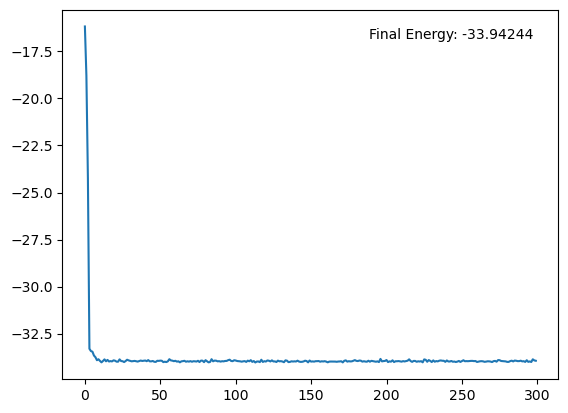

In [51]:
# get final energy from logger dict
final_energy = logger.data['Energy']['Mean'][-1]

plt.plot(logger.data['Energy']['iters'],  logger.data['Energy']['Mean'])# - e_gs)
plt.text(0.95, 0.95, f"Final Energy: {final_energy:.5f}", ha='right', va='top', transform=plt.gca().transAxes)
plt.show()